In [3]:
from res_result import *
sns.set(style='whitegrid')
%pylab inline
path = './res/count_k1000000_10000000_1.5/'

Populating the interactive namespace from numpy and matplotlib


/home/ch/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['plot']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [11]:
ls ./res/count_k1000000_10000000_1.5/

1024_1_4_1_4096         310660_5_7_1_10873100     543656_5_4_32_10873120
1087313_5_2_1_10873130  32_32_4_1_4096            543656_5_4_4096_10873120
128_8_4_1_4096          33978_5_64_1_10872960     543656_5_4_4_10873120
135914_5_16_1_10873120  362437_5_6_1_10873110     543656_5_4_512_10873120
16_64_4_1_4096          4247_5_512_1_10872320     543656_5_4_64_10873120
16989_5_128_1_10872960  434925_5_5_1_10873125     543656_5_4_8_10873120
2123_5_1024_1_10869760  512_2_4_1_4096            543656_5_4_8192_10873120
217462_5_10_1_10873100  543656_5_4_1024_10873120  64_16_4_1_4096
2174626_5_1_0_10873130  543656_5_4_1_10873120     67957_5_32_1_10873120
2174626_5_1_1_10873130  543656_5_4_128_10873120   724875_5_3_1_10873125
2174626_5_4_1_43492520  543656_5_4_16_10873120    8_128_4_1_4096
241625_5_9_1_10873125   543656_5_4_2048_10873120  8494_5_256_1_10872320
256_4_4_1_4096          543656_5_4_2_10873120
271828_5_8_1_10873120   543656_5_4_256_10873120


In [25]:
r = pd.DataFrame()
c = 0

for dirpath, dirnames, filenames in os.walk(path):
    print("has {} files".format(len(filenames)))
    for f in filenames:
        w, d, rows, t, T = f.split('_')
        if rows=='4' and t=='0':
            w, d, rows, t, T = f.split('_')
            #plot_topk('res/'+f, small_w=int(w), depth=int(d), layers=int(rows), topk=1000)
            r = r.append(read_res(f, path ))
            print(c, f)
            c+= 1
    break

has 54 files
0 135914_16_4_0_8698496
1 543656_4_4_0_8698496
2 543656_5_4_0_10873120
3 1087313_2_4_0_8698504
4 271828_8_4_0_8698496
5 67957_32_4_0_8698496


## Fix memory space, find the best height

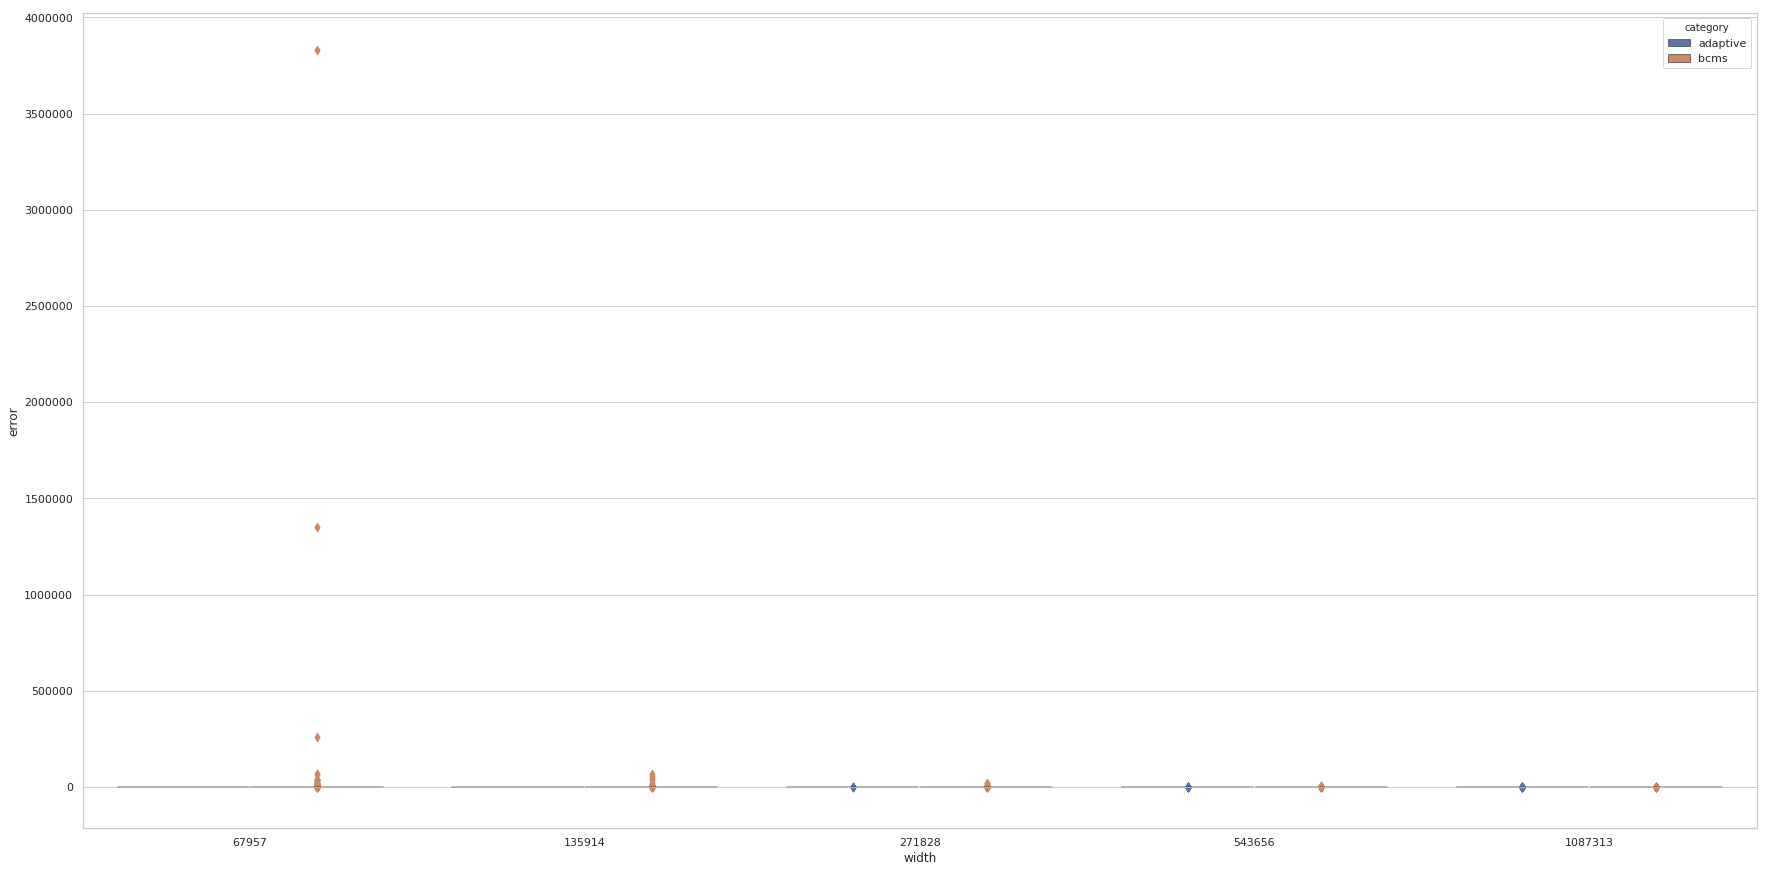

In [27]:
plt.figure(figsize=[30,15])
sns.boxenplot(x='width', y='error', hue='category', data=r)
#plt.ylim([0,1])
#ax = sns.lineplot(x="width", y="error", hue='category', data=r)
#ax = sns.swarmplot(x='width', y='error', hue='category', data=r)
#plt.ylim([0,100])

(0, 50)

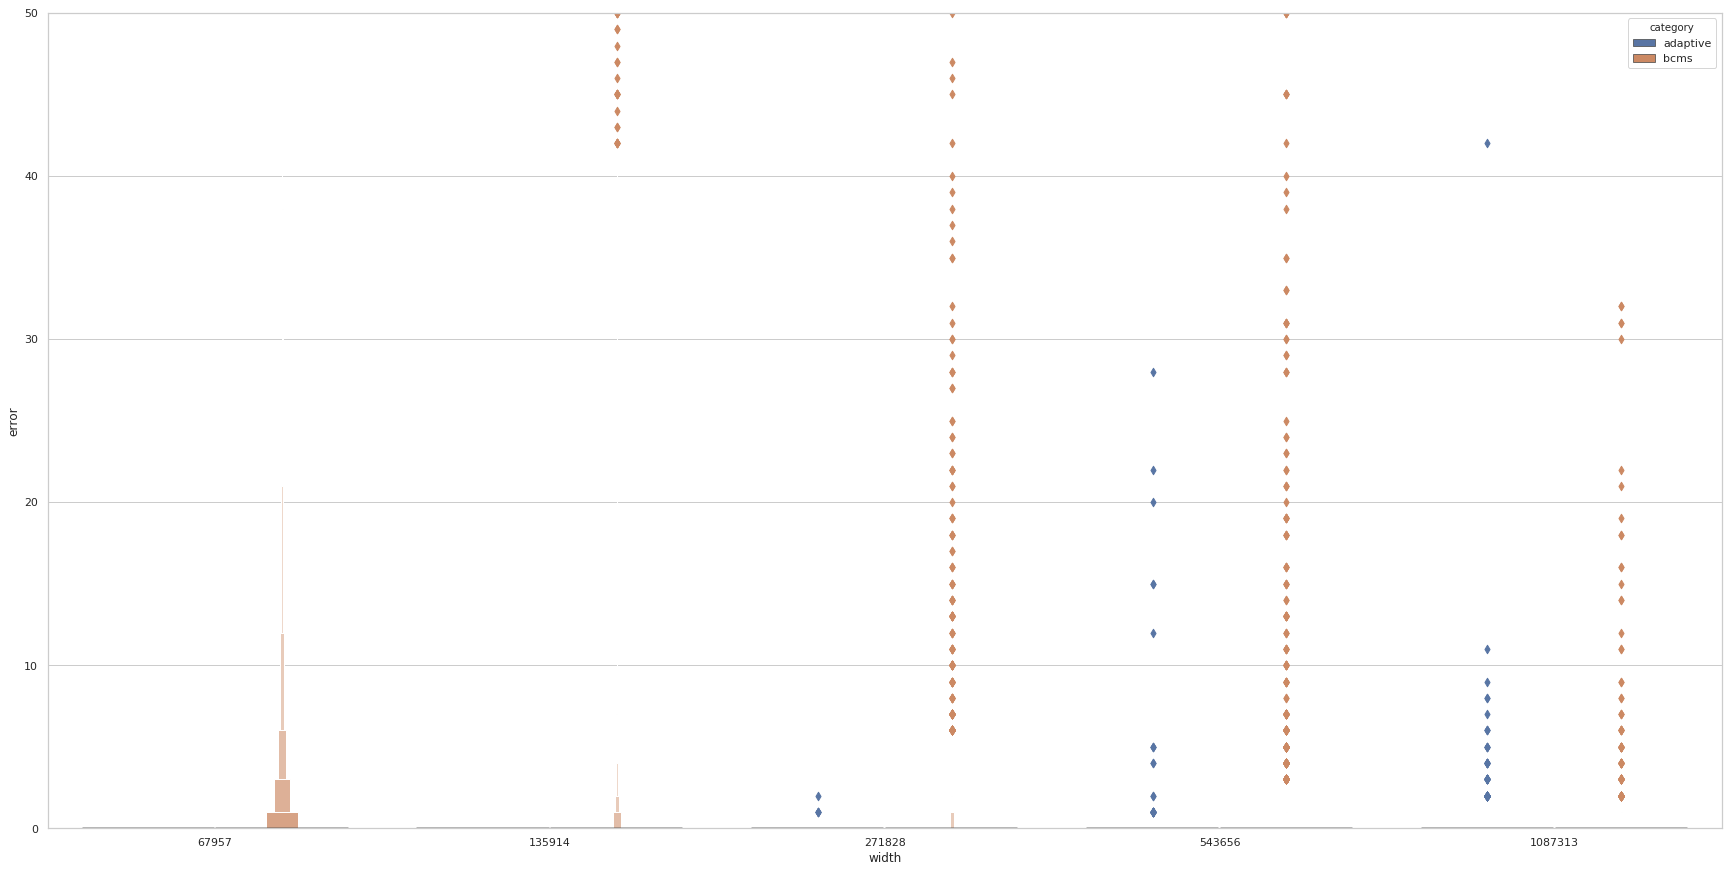

In [28]:
# zoom in 
plt.figure(figsize=[30,15])
sns.boxenplot(x='width', y='error', hue='category', data=r)
plt.ylim([0,50])

(0, 50)

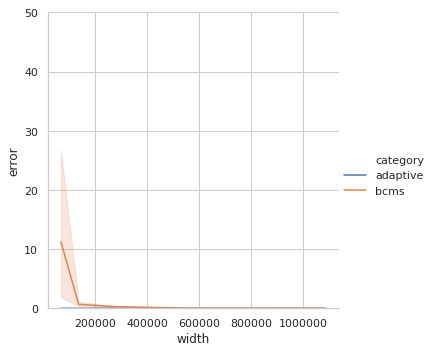

In [29]:
# lineplot: 
sns.relplot(x="width", y="error", hue='category', kind='line', data=r)
plt.ylim([0,50])
# when adaptive width=256 or 512, big cms's width = 256*4, 512*4, the two performs similar
# pick height=4096/4/512 = 2 for future experiment

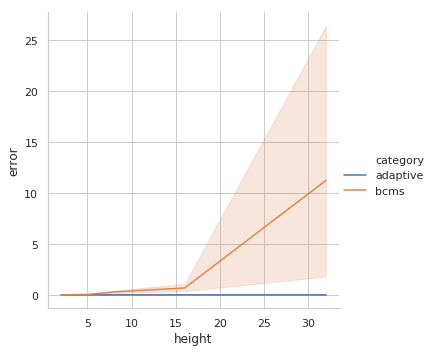

In [30]:
#line plot on height
sns.relplot(x="height", y="error", hue='category', kind='line', data=r)
#plt.xlim([600,1000])
#plt.ylim([0,10])

## Fix memory, investigate rows. adaptive rows = 4096/2/width

In [32]:
r_rows = pd.DataFrame()
c = 0
for dirpath, dirnames, filenames in os.walk(path):
    print("has {} files".format(len(filenames)))
    for f in filenames:
        w, d, rows, t, T = f.split('_')
        if T=='10873120' and t=='0' and d=='5':
            w, d, rows, t, T = f.split('_')
            #plot_topk('res/'+f, small_w=int(w), depth=int(d), layers=int(rows), topk=1000)
            r_rows = r_rows.append(read_res(f, path))
            print(c, f)
            c+= 1
    break

has 62 files
0 543656_5_4_0_10873120
1 67957_5_32_0_10873120
2 135914_5_16_0_10873120
3 271828_5_8_0_10873120


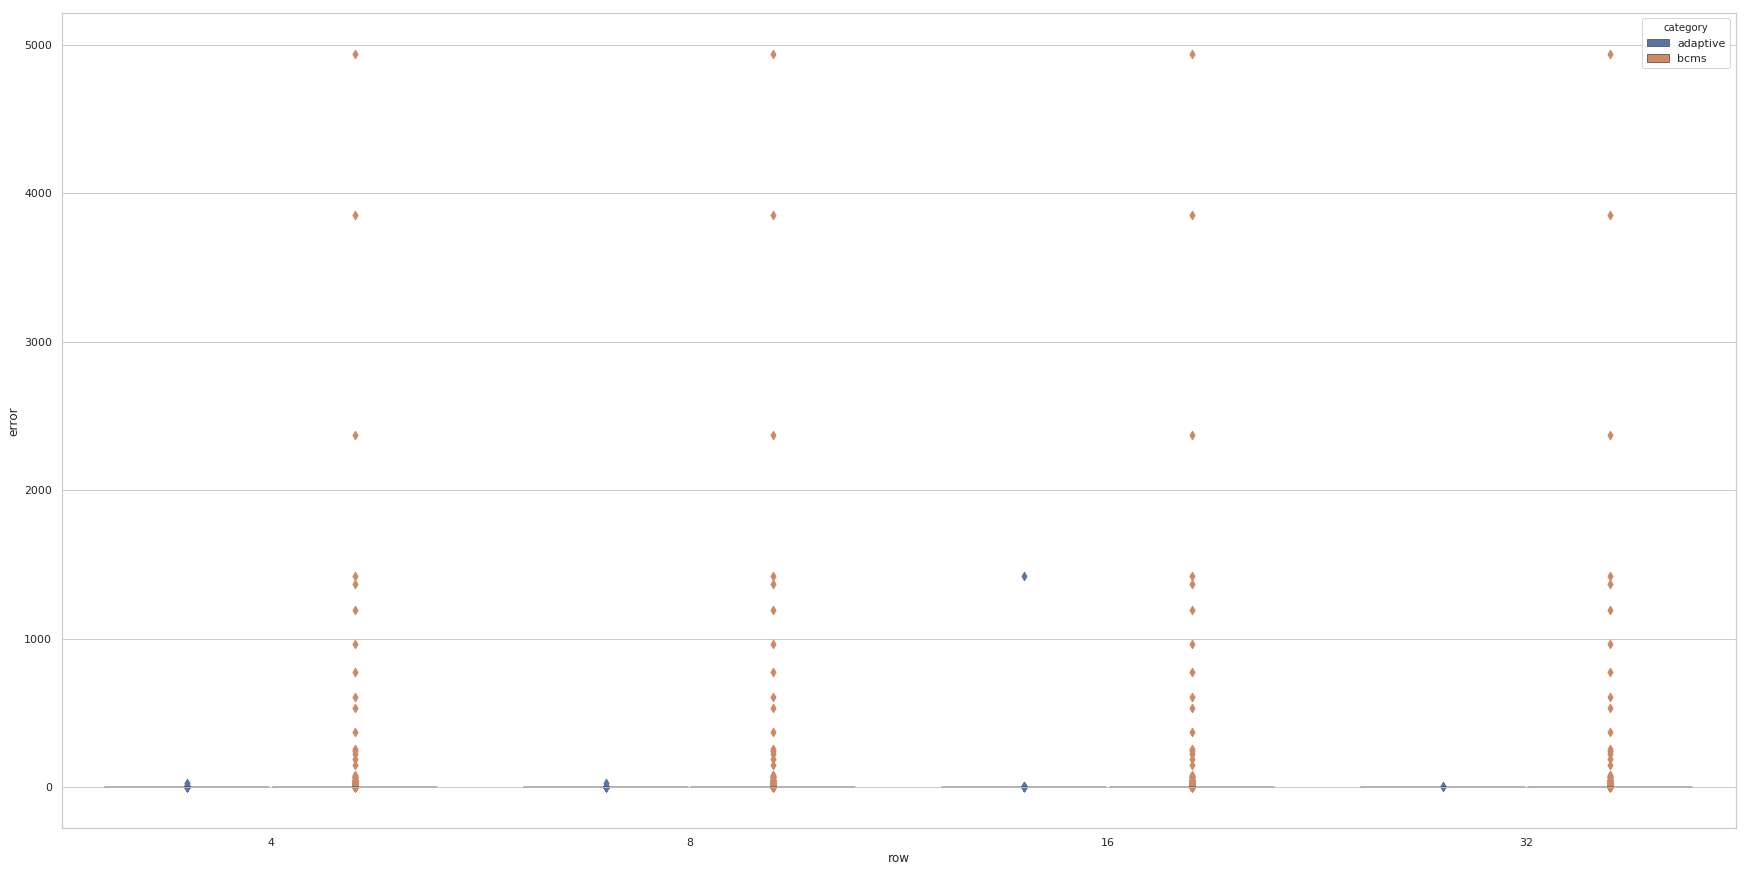

In [35]:
plt.figure(figsize=[30,15])
sns.boxenplot(x='row', y='error', hue='category', data=r_rows)
#plt.ylim([0,2])

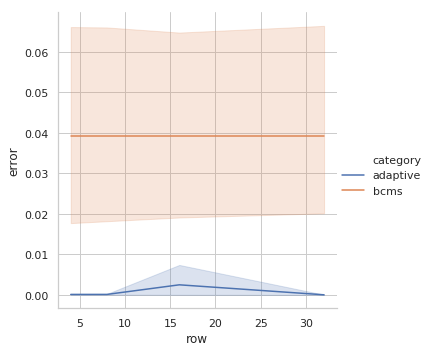

In [36]:
sns.relplot(x="row", y="error", hue='category', kind='line', data=r_rows)
#plt.ylim([0,10])
#plt.xlim([1,20])

Note in the above plot, big cms is the same across x axis because row == 1, width == 4096/2  
experiment 'row' linearly over [1, 10]

In [ ]:
r_rows_zoom = pd.DataFrame()
c = 0
for dirpath, dirnames, filenames in os.walk(path):
    print("has {} files".format(len(filenames)))
    for f in filenames:
        w, d, rows, t, T = f.split('_')
        if (int(d)==2) and (int(rows)<=10) and int(t)==1:
            #plot_topk('res/'+f, small_w=int(w), depth=int(d), layers=int(rows), topk=1000)
            r_rows_zoom = r_rows_zoom.append(read_res(f, path))
            print(c, f)
            c+= 1
        else:
            continue
    break

In [ ]:
sns.relplot(x="row", y="error", hue='category', kind='line', data=r_rows_zoom)
plt.ylim([0,10])
plt.xlim([1,10])

In [ ]:
#see the top10 item error
r_rows_top = {}
for i in range(10):
    k = (i+1)*10
    r_rows_top[k] = pd.DataFrame()
c = 0
for dirpath, dirnames, filenames in os.walk(path):
    print("has {} files".format(len(filenames)))
    for f in filenames:
        w, d, rows, t, T = f.split('_')
        if d=='2' and t=='1' and int(rows)<=10:
            w, d, rows, t, T = f.split('_')
            #plot_topk('res/'+f, small_w=int(w), depth=int(d), layers=int(rows), topk=1000)
            for i in range(10):
                k = (i+1)*10
                r_rows_top[k] = r_rows_top[k].append(read_res_topk(f, k, path))
            #print(c, f)
            c+= 1
    break
for i in range(10):
    k = (i+1)*10
    sns.relplot(x="row", y="error", hue='category', kind='line', data=r_rows_top[k])
    #plt.title('top {}'.format(k))
#plt.ylim([0,10])
#plt.xlim([1,10])

## From the plot above, row=4 is optimized
Note in the above plot, big cms changes because row == 1, width = total_memory/2. And total_memory flucatuate because of floating numbers

## experiment over threshold. Fix CMS configure: width=512, height=2, row=2
### total memory = 2048

In [ ]:
r_threshold = pd.DataFrame()
c = 0
for dirpath, dirnames, filenames in os.walk(path):
    #print("has {} files".format(len(filenames)))
    for f in filenames:
        w, d, rows, t, T = f.split('_')
        if (int(w)==512) and (int(d)==2) and (int(rows)==2):
            #plot_topk('res/'+f, small_w=int(w), depth=int(d), layers=int(rows), topk=1000)
            r_threshold = r_threshold.append(read_res(f, path))
            #print(c, f)
            c+= 1
        else:
            continue
    break

In [ ]:
with open('res/exp_threshold_capacity', 'r') as f:
    c = f.readlines()
li=1
capacities = []
for i in range(17):
    
    threshold = 1<<i
    capacity = float(c[5*(i+1)-1].split(' ')[-1])
    capacities.append(capacity)

In [ ]:
capacities

In [ ]:
plt.figure(figsize=[30,15])
sns.boxplot(x='threshold', y='error', hue='category', data=r_threshold)
plt.ylim([0,2])

In [ ]:
sns.relplot(x="threshold", y="error", hue='category', kind='line', data=r_threshold)
#plt.ylim([0,10])
plt.xlim([1,20000])

In [ ]:
k=10
r_threshold_topk = pd.DataFrame()
c = 0
for dirpath, dirnames, filenames in os.walk('./res/'):
    print("has {} files".format(len(filenames)))
    for f in filenames:
        w, d, rows, t, T = f.split('_')
        if (int(w)==512) and (int(d)==2) and (int(rows)==4):
            #plot_topk('res/'+f, small_w=int(w), depth=int(d), layers=int(rows), topk=1000)
            r_threshold_topk = r_threshold_topk.append(read_res_topk(f, k))
            #print(c, f)
            c+= 1
        else:
            continue
    break

sns.relplot(x="threshold", y="error", hue='category', kind='line', data=r_threshold_topk)
plt.title('error vs. threshold on top {} items'.format(k))
#plt.ylim([0,10])
plt.xlim([1,20000])

In [ ]:
k=20
r_threshold_topk = pd.DataFrame()
c = 0
for dirpath, dirnames, filenames in os.walk('./res/'):
    #print("has {} files".format(len(filenames)))
    for f in filenames:
        w, d, rows, t, T = f.split('_')
        if (int(w)==512) and (int(d)==2) and (int(rows)==4):
            #plot_topk('res/'+f, small_w=int(w), depth=int(d), layers=int(rows), topk=1000)
            r_threshold_topk = r_threshold_topk.append(read_res_topk(f, k))
            c+= 1
        else:
            continue
    break

sns.relplot(x="threshold", y="error", hue='category', kind='line', data=r_threshold_topk)
plt.title('error vs. threshold on top {} items'.format(k))
#plt.ylim([0,10])
plt.xlim([1,20000])

In [ ]:
k=30
r_threshold_topk = pd.DataFrame()
c = 0
for dirpath, dirnames, filenames in os.walk('./res/'):
    #print("has {} files".format(len(filenames)))
    for f in filenames:
        w, d, rows, t, T = f.split('_')
        if (int(w)==512) and (int(d)==2) and (int(rows)==4):
            #plot_topk('res/'+f, small_w=int(w), depth=int(d), layers=int(rows), topk=1000)
            r_threshold_topk = r_threshold_topk.append(read_res_topk(f, k))
            c+= 1
        else:
            continue
    break

sns.relplot(x="threshold", y="error", hue='category', kind='line', data=r_threshold_topk)
plt.title('error vs. threshold on top {} items'.format(k))
#plt.ylim([0,10])
plt.xlim([1,20000])

In [ ]:
k=40
r_threshold_topk = pd.DataFrame()
c = 0
for dirpath, dirnames, filenames in os.walk('./res/'):
    #print("has {} files".format(len(filenames)))
    for f in filenames:
        w, d, rows, t, T = f.split('_')
        if (w=='512') and (d=='2') and (rows=='4'):
            #plot_topk('res/'+f, small_w=int(w), depth=int(d), layers=int(rows), topk=1000)
            r_threshold_topk = r_threshold_topk.append(read_res_topk(f, k))
            c+= 1
        else:
            continue
    break

sns.relplot(x="threshold", y="error", hue='category', kind='line', data=r_threshold_topk)
plt.title('error vs. threshold on top {} items'.format(k))
#plt.ylim([0,10])
plt.xlim([1,20000])

d = ln(1/lambda)  
lambda = 1/(e^d)  
with pr 1-lambda = 80%, error is within bound  
lambda = 0.2  

In [ ]:
p = 0.95 #probability
d = log(1/(1-p))
print(d)

Increase data to keys=1m, stream=100m  
Use the same space, experiment over adapive cms and cms

In [ ]:
rr = read_res_fix_memory('512_3_8_10000_12288')

In [ ]:
sns.relplot(x="category", y="error", kind='line', data=rr)
plt.title('error vs. threshold on top {} items'.format(10))

In [ ]:
def read_res_fix_memory(f):
    adaptives = []
    cmss = []
    big_cmss = []
    true_counts = []
    #64_4_16_1000_4096
    width, depth, row, threshold, memory = list(map(int, f.split('_')))
    small_w = width
    with open('res/'+f, 'r') as f:
    #with open('res_zipf', 'r') as f:
        res = f.readlines()

    n = len(res[0].split(',')) - 3
    nn=0
    for l in res:
        
        ll = l.split(',')
        adaptive = ll[0]
        big_cms = list(map(int, ll[1:1+n]))
        cms = ll[-2] 
        true_count  = ll[-1]
        #keys.append(k1)
        adaptives.append(int(adaptive))
        big_cmss.append(big_cms)
        cmss.append(int(cms))
        true_counts.append(int(true_count))
        nn += 1
        if nn>1000:
            break
    c = ['adaptives',
          'cms',
          'true_count']
    c.extend(range(n))
    d = pd.DataFrame(columns=c)

    d.adaptives = adaptives
    d.cms = cmss
    d.true_count = true_counts
    for i in range(n):
        d[i] = list(map(lambda x: x[i], big_cmss))
        
    d_err = pd.DataFrame(columns=['width', 'height', 'row', 'threshold', 'category', 'error' ])
    #d.iloc[:, :-1] = 1.0 * (d.iloc[:, :-1]-d.loc[:, 'true_count']) / d.loc[:, "true_count"] #.apply(error_dt, axis=1)
    tc = d.true_count
    d = d.sub(tc, axis=0)
    d = d.div(tc, axis=0)
    t = pd.DataFrame(list(map(lambda x: [width, depth, row, threshold, 'adaptive', x], d.adaptives)), 
                     columns=['width', 'height', 'row', 'threshold', 'category', 'error' ])
    d_err = d_err.append(t)
    t = pd.DataFrame(list(map(lambda x: [width, depth, 1, threshold, 'scms', x], d.cms)), 
                     columns=['width', 'height', 'row', 'threshold', 'category', 'error' ])
    d_err = d_err.append(t)
    
    for i in range(n):
        t = pd.DataFrame(list(map(lambda x: [width*(1<<i), depth*(1<<(3-i)), row, threshold, 'bcms_{}'.format(i), x],\
                                  d[i])), 
                        columns=['width', 'height', 'row', 'threshold', 'category', 'error' ])
        d_err = d_err.append(t)
    
    big_w = small_w * row
    small_epsilon = np.e / small_w
    big_epsilon = np.e / big_w

    s_add_error = small_epsilon * sum(d.true_count)
    b_add_error = big_epsilon * sum(d.true_count)

    #d_err['cms_error_bound'] = list(map(lambda x: 1.0 * (s_add_error) / x[3], d_error))
    #d_err['bcms_error_bound'] = list(map(lambda x: 1.0 * (b_add_error) / x[3], d_error))

    m_error = np.mean(d_err[:(1<<10)])
    m_error_a = np.mean(d_err)

    return d_err

# for a bigger dataset: of stream 10m, distinct keys 1m

In [ ]:
print(cal_depth(0.99))

print(8 * np.e / 10 * 1000000)

In [8]:
with open('res/big/543657_5_4_0_10873140', 'r') as f:
    rr = f.readlines()
    

In [9]:
rr

[]

In [4]:
r = read_res_fix_memory('543657_5_4_0_10873140', 'res/big/')

IndexError: list index out of range